# Sprint 公開されている実装を動かす

## 【問題1】学習と推定

### Sprint17_colab版の準備.ipynbの実行で動いた(以下Gitに保存)

https://github.com/satomi23/diveintocode-ml/blob/master/Sprint17_colab%E7%89%88%E3%81%AE%E6%BA%96%E5%82%99.ipynb

## 【問題2】論文と実装の対応

### 構成

①train.py  
  →faster_rcnn.py   
  →config.py, data_generators.py  

②faster_rcnn.py  
  → losses.py, resnet.py() 
 
③resnet.py  
  →RoiPoolingConv.py,FixedBatchNormalization.py
  
②data_generators.py   
  →data_augment.py


### RPNを実現しているコードはどこか

In [ ]:
def rpn(base_layers,num_anchors):

    x = Convolution2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Convolution2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Convolution2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

### RoIプーリングを実現しているコードはどこか

In [ ]:
class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(1, rows, cols, channels)` if dim_ordering='tf'.
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.image_data_format()
        assert self.dim_ordering in {'channels_last', 'channels_first'}, 'dim_ordering must be in {channels_last, channels_first}'

        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'channels_first':
            self.nb_channels = input_shape[0][1]
        elif self.dim_ordering == 'channels_last':
            self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        if self.dim_ordering == 'channels_first':
            return None, self.num_rois, self.nb_channels, self.pool_size, self.pool_size
        else:
            return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        img = x[0]
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            row_length = w / float(self.pool_size)
            col_length = h / float(self.pool_size)

            num_pool_regions = self.pool_size

            #NOTE: the RoiPooling implementation differs between theano and tensorflow due to the lack of a resize op
            # in theano. The theano implementation is much less efficient and leads to long compile times

            if self.dim_ordering == 'channels_first':
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = x + ix * row_length
                        x2 = x1 + row_length
                        y1 = y + jy * col_length
                        y2 = y1 + col_length

                        x1 = K.cast(x1, 'int32')
                        x2 = K.cast(x2, 'int32')
                        y1 = K.cast(y1, 'int32')
                        y2 = K.cast(y2, 'int32')

                        x2 = x1 + K.maximum(1,x2-x1)
                        y2 = y1 + K.maximum(1,y2-y1)

                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]

                        x_crop = img[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

            elif self.dim_ordering == 'channels_last':
                x = K.cast(x, 'int32')
                y = K.cast(y, 'int32')
                w = K.cast(w, 'int32')
                h = K.cast(h, 'int32')

                rs = tf.image.resize_images(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
                outputs.append(rs)

        final_output = K.concatenate(outputs, axis=0)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        if self.dim_ordering == 'channels_first':
            final_output = K.permute_dimensions(final_output, (0, 1, 4, 2, 3))
        else:
            final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output

In [1]:
from IPython.display import display
from PIL import Image

## 【問題3】学習済みの重みによる推定

  ### サンプルデータとしてフォルダに準備されていた画像で推定

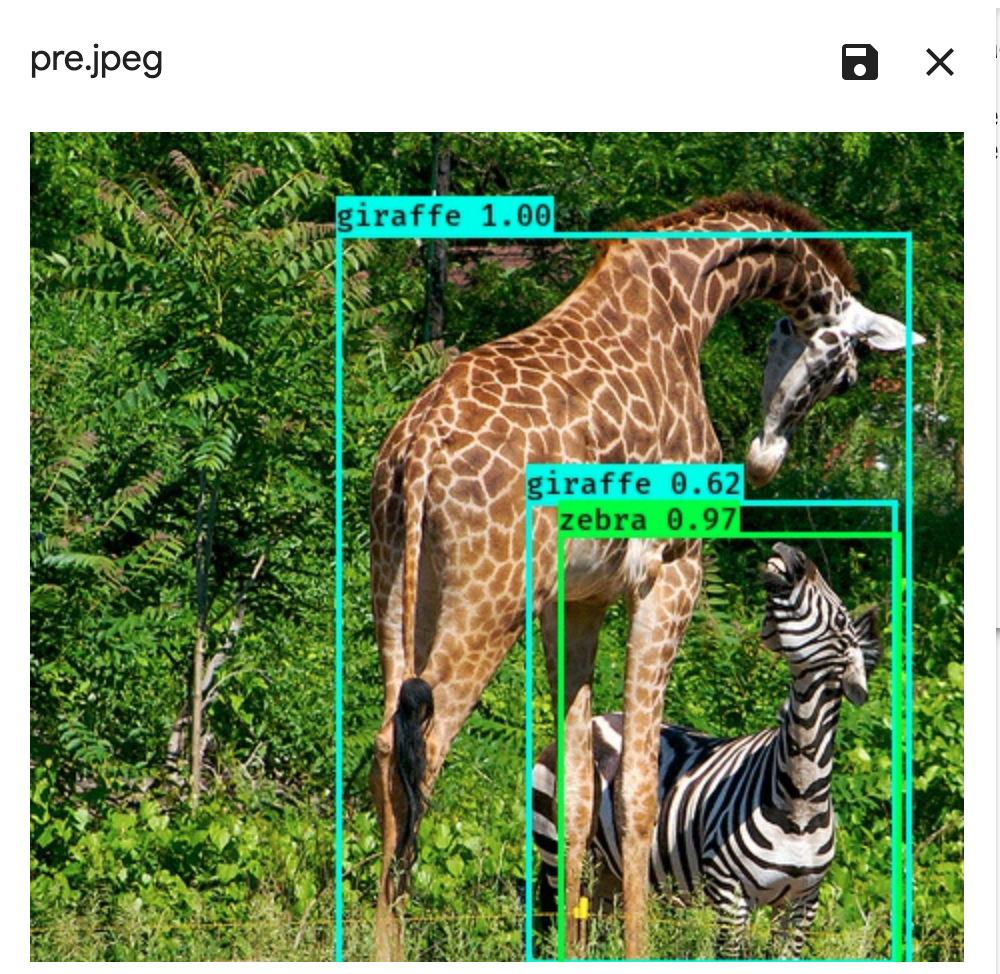

In [2]:
kirin = "スクリーンショット 2019-12-18 14.42.43.png"
display(Image.open(kirin))

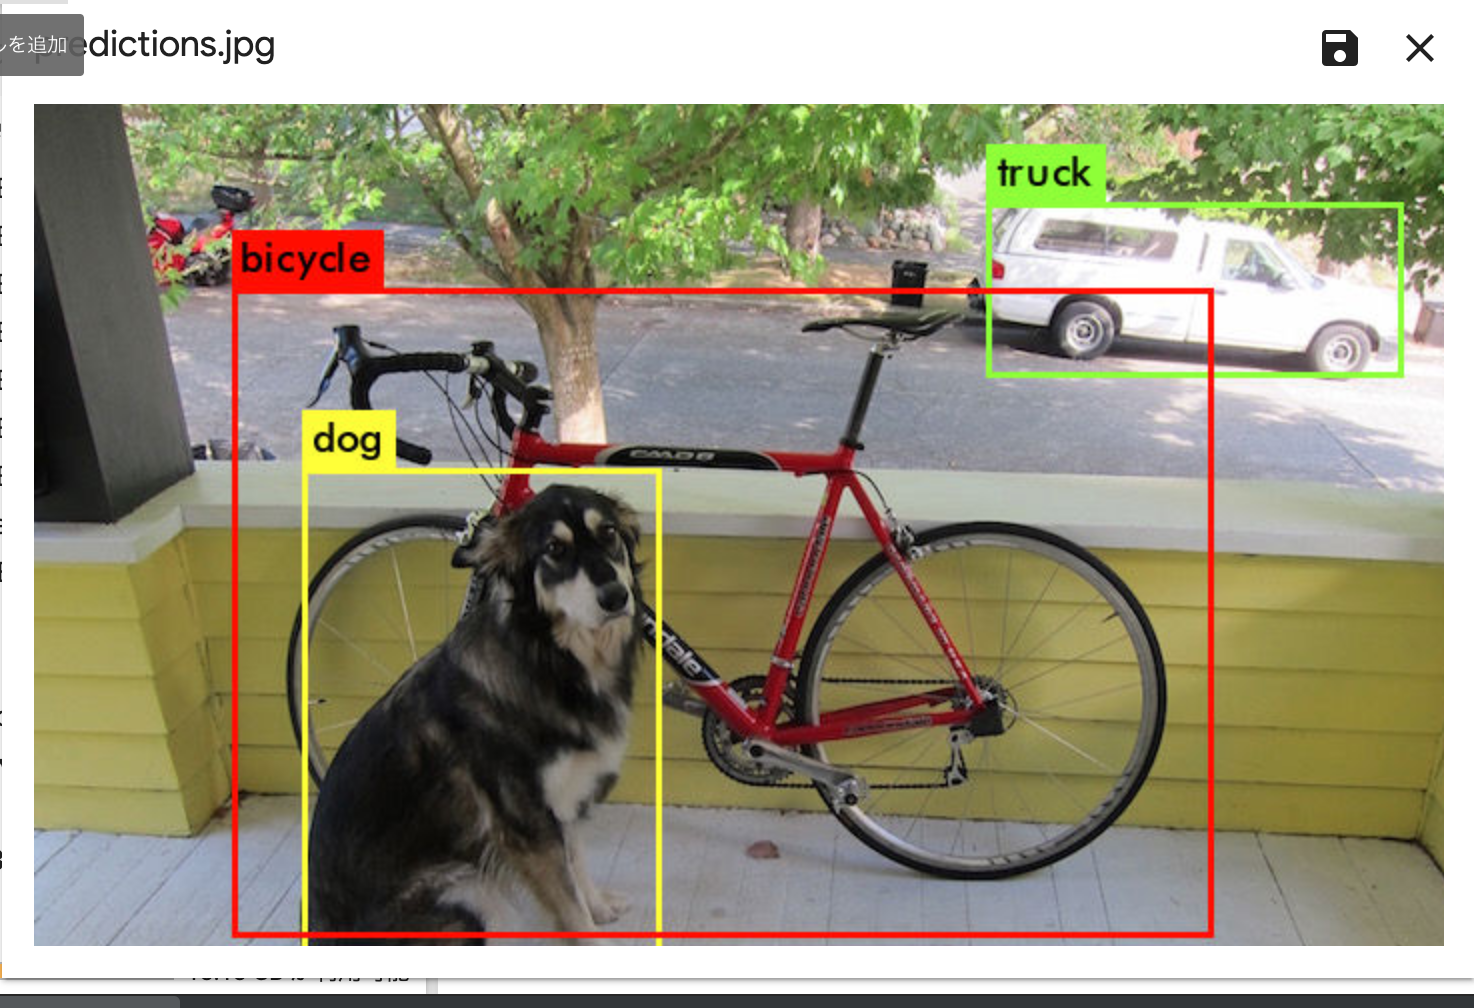

In [5]:
inu = "スクリーンショット 2019-12-18 13.33.05.png"
display(Image.open(inu))

## 【問題4】学習のためのファイルを作成

#### アノテーションファイルを以下のように修正

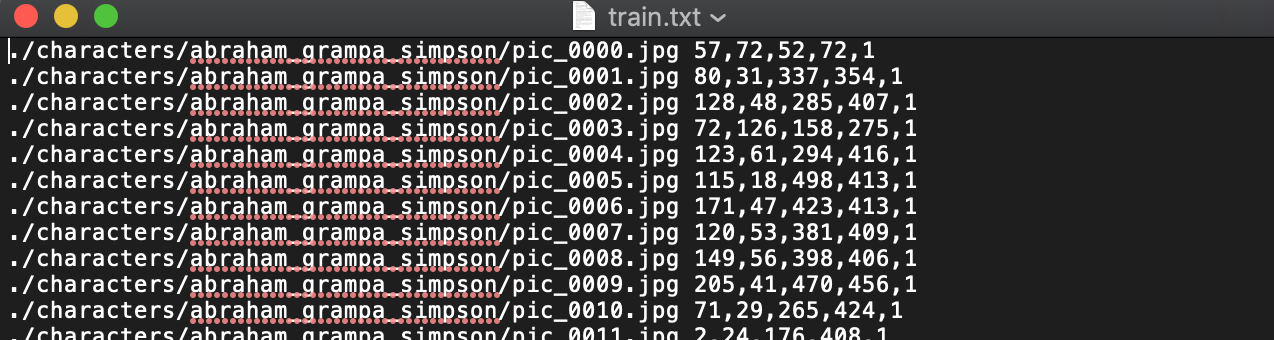

In [6]:
trainfil = "スクリーンショット 2019-12-21 15.44.29.png"
display(Image.open(trainfil))

#### Class_idに対するシンプソンズ仲間の名前をClassファイルに記載

## 【問題5】学習が行えることの確認

### 実行ファイルを以下Gitに保存　2時間くらいトレイン回したが、処理終わらず断念

https://github.com/satomi23/diveintocode-ml/blob/master/Sprint17_yolo.ipynb